# Figure 4: Hammett Plot for pH = 1.0 ($\log{k_{H^+}}$ vs $\sigma$)

This workbook imports the data set of kinetic parameters for the rearrangement described in the paper below. It then generates a Hammett plot for the reaction indicated in the title.

The data being pklotted is from 'On the Rearrangement in Dioxane/Water of (*Z*)-Arylhydrazones of 5-Amino-3-benzoyl-1,2,4-oxadiazole into (2-Aryl-5-phenyl-2*H*-1,2,3-triazol-4-yl)ureas: Substituent Effects on the Different Reaction Pathways." F. D'Anna, V. Frenna, G. Macaluso, S. Marullo, S. Morganti, V. Pace, D. Spinelli, R. Spisani, C. Tavani, *J. Org. Chem.*, **2006**, *71*, 5616-5624. https://doi.org/10.1021/jo0605849

The data is found in tables within the supplementary material at https://ndownloader.figstatic.com/files/4775281


## Setup Tools and Read Data Table

The libraries are imported and any functions defined

In [73]:
##############################################################
### Set up libraries and global variables
##############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar



github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_23/data/"
github_location = "./data/"    ### Use when working file is being stored locally
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

result_file_name = "Table1data.csv"

#################################################################
### a function to fill in sigma for empty spaces in s+ and s- 
#################################################################
def fill_sigma(df):     
    for z in df.index:
        if np.isnan(df.loc[z,"s_plus"]):
            df.loc[z,"s_plus"] = df.loc[z,"sigma"]
        if np.isnan(df["s_minus"][z]):
            df.loc[z,"s_minus"] = df.loc[z,"sigma"]
    return(df)

###############################################################
### a function to report the results from a linear regression
###############################################################

def Report(comment, linefit):
    print(comment)
    print(f"slope = {linefit.slope:-.3f} +/- {linefit.stderr:.3f}")
    print(f"intercept = {linefit.intercept:-.3f} +/- {linefit.intercept_stderr:.3f}")
    print(f"rsq = {(linefit.rvalue)**2:-.3}")
    print(f"p = {(linefit.pvalue):-.3}")
    print("")



## Read Data and Make Result DataFrame

We now have a data set of kinetic parameters and substituent parameters.  We can plot the log of the rate constants *vs* the Hammett $\sigma$ values and draw conclusion based on the results.First we will combine the data from the paper with the database of hammett parameters and create a dataframe caleed 'result'

We will use this data set in all subsequent plots and analyses.

In [74]:
################################################################################
### Load in data file
################################################################################

Filename = github_location + result_file_name        

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 

#display(df)

################################################################################
################################################################################
################################################################################



################################################################################
### Read Hammett data set. The fields are separated by commas; comments are enabled  
################################################################################

#LFER_Data = "LFER_HanschLeoTaft.csv"   # Choose which set of Hammett parameters you prefer
LFER_Data = "LFER_Williams.csv"

Filename = github_location_LFER_tables + LFER_Data

df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 
#display(df)

################################################################################
### Fill across sigma values and select substituents 
################################################################################

df2 = fill_sigma(df2)
#display(df2)

################################################################################
### Remove unneweded columns 
################################################################################
 
#df2.drop(labels = ["TABLE V", "TABLE I"],    #Trim "LFER_HanschLeoTaft.csv" data
df2.drop(labels = ["Page"],                   #Trim "LFER_Williams.csv"" data
        axis = 1,
        inplace = True)

df2.sort_values(by=['sigma'], inplace=True)

result = pd.concat([df2, df], axis=1, join="inner")   # combine the experimental data and the Hammett parameters
display(result)

,sigma,s_plus,s_minus,Molecule,kAR_pS_11.5,kAR_pS_3.80,kAR_pS_1.0,kH,K
Substituent,,,,,,,,,
p-OCH3,-0.27,-0.78,-0.26,1c,0.00395,1.240000e-05,0.000422,0.002130,1.400
p-CH3,-0.14,-0.31,-0.17,1e,0.00467,1.190000e-05,0.000371,0.001880,1.340
m-CH3,-0.06,-0.06,-0.06,1d,0.00641,9.180000e-06,0.000316,0.001770,1.230
H,0.00,0.00,0.00,1b,0.00368,7.940000e-06,0.000286,0.001580,1.230
p-Cl,0.23,0.11,0.19,1g,0.01610,3.990000e-06,0.000119,0.000726,1.080
p-Br,0.23,0.15,0.25,1i,0.02000,3.440000e-06,0.000105,0.000652,1.060
m-Cl,0.37,0.37,0.37,1f,0.02690,2.710000e-06,0.000078,0.000533,0.976
m-Br,0.39,0.39,0.39,1h,0.03120,2.640000e-06,0.000075,0.000495,0.983
p-CN,0.66,0.66,0.88,1j,0.32100,9.500000e-07,0.000022,0.000155,0.880


## Attempt to reporduce Figure 4 from the paper

the code below will create an IYT plot using the r+ and r- values from the paper.

IYT Plot
slope = -1.166 +/- 0.044
intercept = -0.058 +/- 0.020
rsq = 0.987
p = 7.84e-10



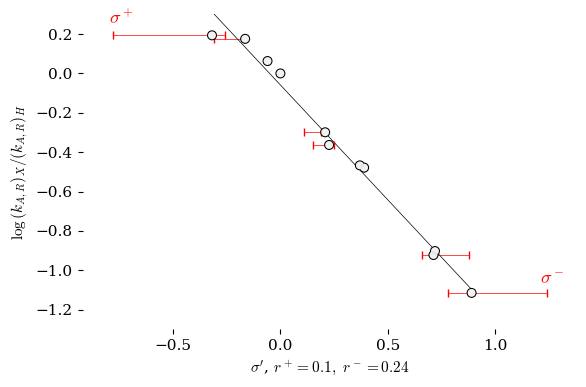

In [75]:
################################################################################
### start with a fresh copy of the data
################################################################################

df = result.copy()    # copy the result so that any changes do not affect the original data

################################################################################
### calculate apparent sigma value using the Ingold-Yukawa-Tsuno equation
################################################################################

r_plus = 0.10
r_minus = 0.24
x = df["sigma"] + r_minus*(df["s_minus"]-df["sigma"]) + r_plus*(df["s_plus"]-df["sigma"])

################################################################################
### calulate log relative rates
################################################################################

y_H = df["kAR_pS_3.80"]["H"]   # The rate constant for the unsubstituted case
y = np.log10(df["kAR_pS_3.80"]/y_H)   

################################################################################
### Create a plot object
################################################################################


style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))  
ax.margins(x=.07, y=.07, tight=True)

x_label = r"$\sigma^\prime$, $r^+ = "+str(r_plus)+r",\ r^- = "+str(r_minus)+r"$"
y_label = r"$\log{(k_{A,R})_X/(k_{A,R})_H}$"
ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-.9,.9],                  
          ylim=[-1.3,0.3]
         )


################################################################################
### Fit the x,y data obtained above to a line and plot the line fit
################################################################################

linfit = linregress(x,y)
fity = linfit.slope * x + linfit.intercept

ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)

################################################################################
### Plot the x,y data 
################################################################################

ax.scatter(x,y, s=52, color="black",  edgecolors = "none", zorder=2)
ax.scatter(x,y, s=32, color="white",  edgecolors = "none", alpha = 1, zorder=2)
ax.scatter(x,y, s=32, color="gray",  edgecolors = "none", alpha = 0.1, zorder=2)

################################################################################
### Plot extra points. here we add in points using the sigma values only for comparison purposes
################################################################################

ax.scatter(df["s_minus"],y, color="red", marker='|', zorder=1)
ax.scatter(df["s_plus"],y, color="red", marker='|', zorder=1)
#ax.scatter(df["sigma"],y, color="blue", marker='|', zorder=1)

################################################################################
### Add text to identify the extra markers
################################################################################

ax.text(-0.80,0.25,r"$\sigma^+$", size = "large", color = "red")
ax.text(1.21,-1.07,r"$\sigma^-$", size = "large", color = "red")

################################################################################
### get fancy and add horizontal lines to connect alternate points with hammett sigma points.
################################################################################

if True:                  # An easy switch to turn this on or off. 'True' for on, 'False' for off.
    for n in df.index:
        yhline = y[n]
        start = df["s_minus"][n]
        end = df["s_plus"][n]
        ax.hlines(yhline, start, end, 
                  color='red', zorder=0, linewidth=0.5)


################################################################################
### Print out the line fit parameters
################################################################################

Report("IYT Plot", linfit)   # use the 'Report' function to output the line fit parameters

################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################

fig.savefig("images/plotIYK_Fig3+0.10+0.24.pdf")   # use this to save the figure in PDF format
plt.show()

## Determine the $r^+$ and $r^-$ values for the IYT Plot

The $r^+$ and $r^-$ values reported in the paper did not correspond to the plot as presented in figure 4 of the paper.  the code below will optimize the plot for $r^+$ and $r^-$ values and I am allowing the values to go negative.

The optimized values will be calculated and a contour plot of all $r^+$ and $r^-$ values bewteen $-1$ and $+1$ will be created as a pdf file

The optimal value for r+ is -0.212 and for r- is 0.248 for rsq = -0.99788


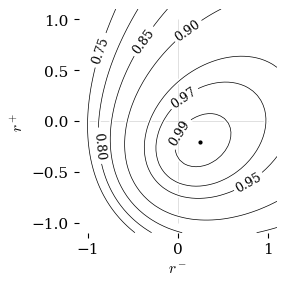

In [76]:
# INGOLD-YUKAWA-TSUNO DETERMINATION

################################################################################
### Define a function to be minimized
################################################################################

def RSQ_function(params):       # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    r_minus, r_plus = params    # extract values from params list
    x = df["sigma"] + r_minus*(df["s_minus"]-df["sigma"]) + r_plus*(df["s_plus"]-df["sigma"])
    linfit = linregress(x,y)    # y is the set of y values from above
    return -(linfit.rvalue**2)



################################################################################
### optimize the param list to obtain the minimum result of the function.
################################################################################

r_opt = minimize(RSQ_function, [1,1])
#print(r_opt)
r_minus, r_plus = r_opt['x']
print(f"The optimal value for r+ is {r_plus:0.3f} and for r- is {r_minus:0.3f} for rsq = {r_opt['fun']:0.5f}")

################################################################################
### Create a plot object
################################################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
ax.margins(x=.07, y=.07, tight=True)

ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=r"$r^+$", 
          xlabel=r"$r^-$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
         )

################################################################################
### use the function to caluate the RSQ for the line fit at every value of r+ and r-
## and then plot the result as a contour plot
################################################################################

rpluslist = np.linspace(-1.1,1.1,50)
rminuslist = rpluslist.copy()          #  vary r_plus and r_minus from -1.1 to +1.1

### This loop cycles through all the pairings of r+ and r- and calculates RSQ for each case
l1 = []                                
for rplus in rpluslist:
    l2 = []
    for rminus in rminuslist:
        rsq = RSQ_function([rminus,rplus])    
        l2.append(rsq)
    l1.append(l2)
l3 = np.matrix(l1)
#print(l3)

### Set up contour plot
X, Y = np.meshgrid(rpluslist, rminuslist)
levels = [0.75, 0.80, 0.85, 0.90, 0.95, 0.97, 0.99]

### plot lines along the x and y axes
ax.hlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)
ax.vlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)

### Plot the contour lines as thick white lines 
ax.contour(X, Y, -l3, levels, colors = "white", linewidths=3, zorder = 2)

### Create contour plot as 'CS' and then plot 'CS' with lables
CS = ax.contour(X, Y, -l3, levels, colors = "black", linewidths=0.5, zorder = 2)
ax.clabel(CS, inline=True, fontsize=9)

### Plot the true minimum value as a point
#ax.plot(r_minus,r_plus,"o", color="white", markeredgecolor = "black", markeredgewidth = 0.5, markersize = 3)
ax.plot(r_minus,r_plus,"o", color="black", markersize = 2)


################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################


fig.savefig("images/plotIYK_Fig3_r+r-_opt.pdf")   # use this to save the figure in PDF format

plt.show()



## Plot IYT using optimized $r^+$ and $r^-$ values

The $r^+$ and $r^-$ values have been optimized and they are different than in the paper.  To obtain a plot that resembles figure 4 I found that the $r^+$ value had to be negative.

the code below will plot the IYT plot again using my own values for $r^+$ and $r^-$.

IYT Plot
slope = -1.261 +/- 0.019
intercept = -0.001 +/- 0.009
rsq = 0.998
p = 2.41e-13



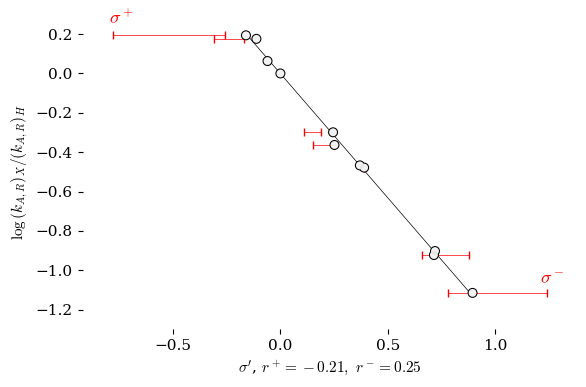

In [77]:
################################################################################
### start with a fresh copy of the data
################################################################################

df = result.copy()    # copy the result so that any changes do not affect the original data

################################################################################
### calculate apparent sigma value using the Ingold-Yukawa-Tsuno equation
################################################################################

r_plus = -0.21
r_minus = 0.25
x = df["sigma"] + r_minus*(df["s_minus"]-df["sigma"]) + r_plus*(df["s_plus"]-df["sigma"])

################################################################################
### calulate log relative rates
################################################################################

y_H = df["kAR_pS_3.80"]["H"]   # The rate constant for the unsubstituted case
y = np.log10(df["kAR_pS_3.80"]/y_H)   

################################################################################
### Create a plot object
################################################################################


style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))  
ax.margins(x=.07, y=.07, tight=True)

x_label = r"$\sigma^\prime$, $r^+ = "+str(r_plus)+r",\ r^- = "+str(r_minus)+r"$"
y_label = r"$\log{(k_{A,R})_X/(k_{A,R})_H}$"
ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-.9,.9],                  
          ylim=[-1.3,0.3]
         )


################################################################################
### Fit the x,y data obtained above to a line and plot the line fit
################################################################################

linfit = linregress(x,y)
fity = linfit.slope * x + linfit.intercept

ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)

################################################################################
### Plot the x,y data 
################################################################################

ax.scatter(x,y, s=52, color="black",  edgecolors = "none", zorder=2)
ax.scatter(x,y, s=32, color="white",  edgecolors = "none", alpha = 1, zorder=2)
ax.scatter(x,y, s=32, color="gray",  edgecolors = "none", alpha = 0.1, zorder=2)

################################################################################
### Plot extra points. here we add in points using the sigma values only for comparison purposes
################################################################################

ax.scatter(df["s_minus"],y, color="red", marker='|', zorder=1)
ax.scatter(df["s_plus"],y, color="red", marker='|', zorder=1)
#ax.scatter(df["sigma"],y, color="blue", marker='|', zorder=1)

################################################################################
### Add text to identify the extra markers
################################################################################

ax.text(-0.80,0.25,r"$\sigma^+$", size = "large", color = "red")
ax.text(1.21,-1.07,r"$\sigma^-$", size = "large", color = "red")

################################################################################
### get fancy and add horizontal lines to connect alternate points with hammett sigma points.
################################################################################

if True:                  # An easy switch to turn this on or off. 'True' for on, 'False' for off.
    for n in df.index:
        yhline = y[n]
        start = df["s_minus"][n]
        end = df["s_plus"][n]
        ax.hlines(yhline, start, end, 
                  color='red', zorder=0, linewidth=0.5)


################################################################################
### Print out the line fit parameters
################################################################################

Report("IYT Plot", linfit)   # use the 'Report' function to output the line fit parameters

################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################

fig.savefig("images/plotIYK_Fig3-0.21+0.25.pdf")   # use this to save the figure in PDF format
plt.show()

## Determine Yukawa-Tsuno *r*-Value

It would be better to use the simpler Yukawa-Tsuno equation to express the The code below uses the y-data and determines a set of $\sigma$ values based on blending $\sigma$ and $\sigma^-$ values using the Yukawa-Tsuno method.

The optimal value for r is 0.325 for rsq = -0.99326


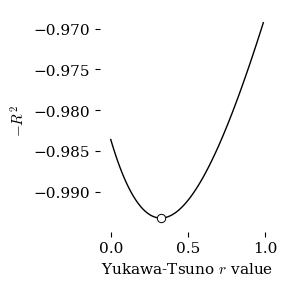

In [78]:
# YUKAWA-TSUNO DETERMINATION

################################################################################
### Define a function to be minimized
################################################################################

def RSQ_function(r):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    x = df["sigma"]+r*(df["s_minus"]-df["sigma"])
    linfit = linregress(x,y)    # y is the set of y values from above
    return -(linfit.rvalue**2)


##########################################################
### Calculate the value of -RSQ as the value of r is varied 
##########################################################

rsq_range=[]
r_range = np.arange(0,1,0.01)
for r in r_range:
    rsq = RSQ_function(r)
    rsq_range.append(rsq)

##########################################################
### Plot the value of -RSQ as the value of r is varied 
##########################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-R^2$", 
       xlabel=r"Yukawa-Tsuno $r$ value")

ax.plot(r_range,rsq_range)

##################################################
### Determine optimal r value to minimize -RSQ 
##################################################

r_opt = minimize_scalar(RSQ_function)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")

ax.scatter(r_opt['x'], r_opt['fun'], 
           marker = "o", linewidth = 0.7, 
           facecolor = "white", edgecolor = "black",
           zorder = 4)

fig.savefig("images/plotYK_Fig3_r.pdf")   # use this to save the figure in PDF format
plt.show()



## Yukawa Tsuno Plot

Below is code to produce a YK plot using the $r^-$ value determined above. The correlation is stil great and we don't have to explain any negative values for $r^+$.

YK Plot
slope = -1.171 +/- 0.032
intercept = -0.042 +/- 0.015
rsq = 0.993
p = 4.4e-11



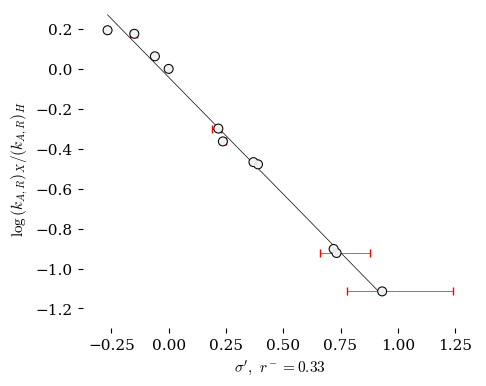

In [79]:
################################################################################
### start with a fresh copy of the data
################################################################################

df = result.copy()    # copy the result so that any changes do not affect the original data

################################################################################
### calculate apparent sigma value using the Ingold-Yukawa-Tsuno equation
################################################################################

r_plus = 0
r_minus = 0.33
x = df["sigma"] + r_minus*(df["s_minus"]-df["sigma"]) + r_plus*(df["s_plus"]-df["sigma"])

################################################################################
### calulate log relative rates
################################################################################

y_H = df["kAR_pS_3.80"]["H"]   # The rate constant for the unsubstituted case
y = np.log10(df["kAR_pS_3.80"]/y_H)   

################################################################################
### Create a plot object
################################################################################


style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.07, y=.07, tight=True)

x_label = r"$\sigma^\prime,\  r^- = "+str(r_minus)+r"$"
y_label = r"$\log{(k_{A,R})_X/(k_{A,R})_H}$"
ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-.9,.9],                  
          ylim=[-1.3,0.3]
         )


################################################################################
### Fit the x,y data obtained above to a line and plot the line fit
################################################################################

linfit = linregress(x,y)
fity = linfit.slope * x + linfit.intercept

ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)

################################################################################
### Plot the x,y data 
################################################################################

ax.scatter(x,y, s=52, color="black",  edgecolors = "none", zorder=2)
ax.scatter(x,y, s=32, color="white",  edgecolors = "none", alpha = 1, zorder=2)
ax.scatter(x,y, s=32, color="gray",  edgecolors = "none", alpha = 0.1, zorder=2)

################################################################################
### Plot extra points. here we add in points using the sigma values only for comparison purposes
################################################################################

ax.scatter(df["sigma"],y, color="red", marker='|', zorder=0)
ax.scatter(df["s_minus"],y, color="red", marker='|', zorder=0)
ax.hlines(y, df["sigma"], df["s_minus"], 
         color = "red", linewidth = 0.5, zorder = 0)


################################################################################
### Print out the line fit parameters
################################################################################

Report("YK Plot", linfit)   # use the 'Report' function to output the line fit parameters

################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################


fig.savefig("images/plotYK_Fig3.pdf")   # use this to save the figure in PDF format
plt.show()


## A Fancy Hammett Plot

Below is code to produce a basic Hammett plot and line fit only the meta substituents.  These meta points are also highlighted by overplotting just those data points again in gray.

this plot is intended to highlight where the deviations are from the line with substituents that have no resonance effects.

kAR pH 1.0
slope = -1.241 +/- 0.013
intercept = -0.004 +/- 0.005
rsq = 1.0
p = 2.41e-06



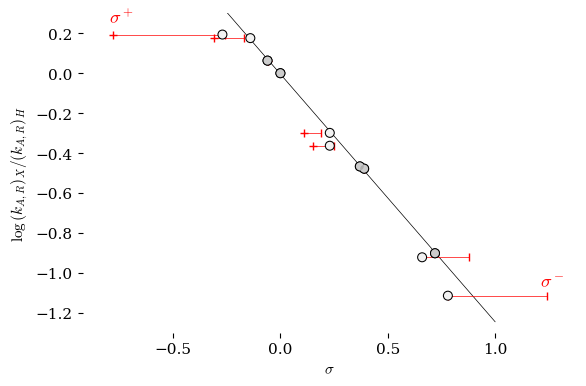

In [80]:
### PLAIN HAMMETT PLOT

################################################################################
### start with a fresh copy of the data
################################################################################

df = result.copy()

################################################################################
### Set up x-axis with sigma values. Also define a list of x-values for plotting the line
################################################################################

x = df["sigma"]

################################################################################
### calulate log relative rates
################################################################################

y_H = df["kAR_pS_3.80"]["H"]
y = np.log10(df["kAR_pS_3.80"]/y_H)   

################################################################################
### Create a plot object
################################################################################


style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))  
ax.margins(x=.07, y=.07, tight=True)

x_label = r"$\sigma$"
y_label = r"$\log{(k_{A,R})_X/(k_{A,R})_H}$"

ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=y_label, 
          xlabel=x_label,                
#          xlim=[-.9,.9],                  
          ylim=[-1.3,0.3]
         )

################################################################################
### Plot all the data points
################################################################################


ax.scatter(x,y, s=52, color="black",  edgecolors = "none", zorder=2)
ax.scatter(x,y, s=32, color="white",  edgecolors = "none", alpha = 1, zorder=2)
ax.scatter(x,y, s=32, color="gray",  edgecolors = "none", alpha = 0.1, zorder=2)


################################################################################
### Plot extra data point markers for sigma_ and sigma- values
################################################################################

#ax.scatter(df["sigma"],y, color="black", marker='|', zorder=2)
ax.scatter(df["s_minus"],y, color="red", marker='|', zorder=0)
ax.scatter(df["s_plus"],y, color="red", marker='+', zorder=0)

################################################################################
### Add text to identify the extra markers
################################################################################

ax.text(-0.80,0.25,r"$\sigma^+$", size = "large", color = "red")
ax.text(1.21,-1.07,r"$\sigma^-$", size = "large", color = "red")

################################################################################
### Pick out the meta substituents only
################################################################################

meta = df.loc[["m-CH3", "m-Cl", "m-Br", "m-NO2", "H"]]   # create a dataframe with only meta substituents

x_meta = meta["sigma"]
y_meta = np.log10(meta["kAR_pS_3.80"]/y_H)

################################################################################
### Plot the meta points in light gray
################################################################################


ax.scatter(x_meta,y_meta, s=52, color="black",  edgecolors = "none", zorder=2)
ax.scatter(x_meta,y_meta, s=32, color="white",  edgecolors = "none", alpha = 1, zorder=2)
ax.scatter(x_meta,y_meta, s=32, color="gray",  edgecolors = "none", alpha = 0.4, zorder=2)

################################################################################
### Fit the x,y data for meta substituents and plot the line fit
################################################################################

linfit = linregress(x_meta,y_meta)

#x_line = np.linspace(np.min(x), np.max(x), 10)   # Plot the line only within the limits of the meta sigma values
x_line = np.linspace(np.min(x), 1.0, 10)          # Plot the line beyond the limits of the meta sigma values

fity = linfit.slope * x_line + linfit.intercept
ax.plot(x_line, fity, color='black', zorder=0, linewidth=0.5)

################################################################################
### get fancy and add horizontal lines to connect alternate points with hammett sigma points.
################################################################################

if True:                  # An easy switch to turn this on or off. 'True' for on, 'False' for off.
    for n in df.index:
        yhline = y[n]
        start = df["s_minus"][n]
        end = df["s_plus"][n]
        ax.hlines(yhline, start, end, 
                  color='red', zorder=0, linewidth=0.5)

################################################################################
### Print out the line fit parameters
################################################################################

Report("kAR pH 1.0", linfit)   # use the 'Report' function to output the line fit parameters

################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################

fig.savefig("images/plot_Hammett_Fig09.pdf")   # use this to save the figure in PDF format
plt.show()

